<a href="https://colab.research.google.com/github/Toandinh1/DeepIM/blob/master/412_QAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.5

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.5`. This will be interpreted as: `1.x`.


After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


In [3]:
import numpy as np
import tensorflow as tf
from scipy.special import binom
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Conv1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.python.ops.gen_math_ops import sign
#from keras import backend as K




N = 4 # number of sub-carriers
K = 1 # number of active sub-carriers
M = 2 # M-ary modulation order

SNRdb = 7 # Training SNR

traing_epochs = 200
l_rate = 0.001
total_batch = 20 # number of batches per epoch
batch_size = 200


n_output_1 = 16
n_output_2 = 32
n_input_1 = N
n_input_2 = 2*N


m = int(np.log2(M))
c = int(np.log2(binom(N,K)))
q = K*m + c # number of bits per OFDM-IM symbol
Q= 2**q
n_output = c

c1 = 4
c2 = 1

SNR = 10**(SNRdb/10)
sigma = np.sqrt(1/SNR)

display_step = 5
qam_factor = (2/3)*(M-1)


a = 1/np.sqrt(2)

# M-ary modulations
if M==4:
    QAM = np.array([1+0j, 0+1j, -0-1j, -1+0j], dtype=complex) # gray mapping
elif M==8:
    QAM = np.array([1, a+a*1j, -a+a*1j, 1j, a-a*1j, -1j, -1, -a-a*1j], dtype=complex) # 8PSK, not 8QAM indeed
    qam_factor = 1
elif M==16:
    QAM = np.array([-3+3j, -3+1j, -3-3j, -3-1j, 
                    -1+3j, -1+1j, -1-3j, -1-1j, 
                    3+3j, 3+1j, 3-3j, 3-1j, 
                    1+3j, 1+1j, 1-3j, 1-1j], dtype=complex)
else:
    QAM = np.array([1+0j,-1+0j], dtype=complex) #BPSK
    qam_factor = 1


# index patterns for N=4 and K=1,2,3 only
if K==1:
    idx = np.array([[0],[1],[2],[3]])
elif K==2:
    idx = np.array([[0,1],[2,3],[0,2],[1,3]]) 
else:
    idx = np.array([[0,1,2],[1,2,3],[0,2,3],[0,1,3]]) 
def SC_IM_NO_train(bit1,bit2, SNRdb):
        #user1
    bit_id1 = bit1[0:c:1]
    id_de1 = bit_id1.dot(2**np.arange(bit_id1.size)[::-1])
    bit_sy1 = bit1[c:q:1]   
    bit_K1 = bit_sy1.reshape(-1,m)
    sy_de1 = np.zeros((K,), dtype=int)
    sym1 = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i1 = bit_K1[i,:]
        sy_de1[i] = bit_sy_i1.dot(2**np.arange(bit_sy_i1.size)[::-1])
        sym1[i] = QAM[sy_de1[i]]

    tx_sym1 = np.zeros((N,), dtype=complex)
    tx_sym1[idx[id_de1,:]] = sym1
    tx_sym1 = tx_sym1*np.sqrt(c1)
  #user2
    bit_id2 = bit2[0:c:1]
    id_de2 = bit_id2.dot(2**np.arange(bit_id2.size)[::-1])
    bit_sy2 = bit2[c:q:1]   
    bit_K2 = bit_sy2.reshape(-1,m)
    sy_de2 = np.zeros((K,), dtype=int)
    sym2 = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i2 = bit_K2[i,:]
        sy_de2[i] = bit_sy_i2.dot(2**np.arange(bit_sy_i2.size)[::-1])
        sym2[i] = QAM[sy_de2[i]]

    tx_sym2 = np.zeros((N,), dtype=complex)
    tx_sym2[idx[id_de2,:]] = sym2
    tx_sym2 = tx_sym2*np.sqrt(c2)

    #transmision
    SNR = 10**(SNRdb/10)
    sigma = np.sqrt(1/SNR)
    noise = sigma*np.sqrt(1/2)*(np.random.randn(*tx_sym1.shape)+1j*np.random.randn(*tx_sym1.shape))
    #noise = sigma*(np.random.normal(0, 1, tx_sym1.shape))
    H1 = 1
    H2 = 1
    
    y = H1*tx_sym1 + H2*tx_sym2 + noise
     
    y_bar = y/ H1
    y_con = np.concatenate((np.real(y_bar),np.imag(y_bar)))
    y_m = np.absolute(y_bar)
    Y =np.concatenate((y_con,y_m))
    
    return y_con
    
  
    

def SC_IM_NO_test(bit1, bit2, SNRdb):
        #user1
    bit_id1 = bit1[0:c:1]
    id_de1 = bit_id1.dot(2**np.arange(bit_id1.size)[::-1])
    bit_sy1 = bit1[c:q:1]   
    bit_K1 = bit_sy1.reshape(-1,m)
    sy_de1 = np.zeros((K,), dtype=int)
    sym1 = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i1 = bit_K1[i,:]
        sy_de1[i] = bit_sy_i1.dot(2**np.arange(bit_sy_i1.size)[::-1])
        sym1[i] = QAM[sy_de1[i]]

    tx_sym1 = np.zeros((N,), dtype=complex)
    tx_sym1[idx[id_de1,:]] = sym1
    tx_sym1 = tx_sym1*np.sqrt(c1)
  #user2
    bit_id2 = bit2[0:c:1]
    id_de2 = bit_id2.dot(2**np.arange(bit_id2.size)[::-1])
    bit_sy2 = bit2[c:q:1]   
    bit_K2 = bit_sy2.reshape(-1,m)
    sy_de2 = np.zeros((K,), dtype=int)
    sym2 = np.zeros((K,), dtype=complex)
    for i in range(K):
        bit_sy_i2 = bit_K2[i,:]
        sy_de2[i] = bit_sy_i2.dot(2**np.arange(bit_sy_i2.size)[::-1])
        sym2[i] = QAM[sy_de2[i]]

    tx_sym2 = np.zeros((N,), dtype=complex)
    tx_sym2[idx[id_de2,:]] = sym2
    tx_sym2 = tx_sym2*np.sqrt(c2)

    #transmision
    SNR = 10**(SNRdb/10)
    sigma = np.sqrt(1/SNR)
    noise = sigma*np.sqrt(1/2)*(np.random.randn(*tx_sym1.shape)+1j*np.random.randn(*tx_sym1.shape))
    #noise = sigma*(np.random.normal(0, 1, tx_sym1.shape))
    H1 = 1
    H2 = 1
    
    y = H1*tx_sym1 + H2*tx_sym2 + noise
     
    y_bar = y/ H1
    y_con = np.concatenate((np.real(y_bar),np.imag(y_bar)))
    y_m = np.absolute(y_bar)
    Y =np.concatenate((y_con,y_m))
    
    return y_con
    



In [4]:
X = tf.placeholder("float", [None, 8])
Y = tf.placeholder("float", [None, 3])
initializer = tf.contrib.layers.xavier_initializer()

def encoder(x):
    weights = {                    
        'encoder_h1': tf.Variable(initializer([8, 32])),
        'encoder_h2': tf.Variable(initializer([32,64])),
        'encoder_h3': tf.Variable(initializer([64, 3])), 
                   
    }
    biases = {            
        'encoder_b1': tf.Variable(initializer([32])),
        'encoder_b2': tf.Variable(initializer([64])),
        'encoder_b3': tf.Variable(initializer([3])),           
    
    }
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
    return layer_3

y_pred = encoder(X)
y_true = Y

cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
learning_rate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
init = tf.global_variables_initializer()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 0001 cost= 0.231351861
Epoch: 0006 cost= 0.133919001
Epoch: 0011 cost= 0.053625286
Epoch: 0016 cost= 0.022714995
Epoch: 0021 cost= 0.012131759
Epoch: 0026 cost= 0.007291733
Epoch: 0031 cost= 0.004946320
Epoch: 0036 cost= 0.003750686
Epoch: 0041 cost= 0.002675306
Epoch: 0046 cost= 0.002488005
Epoch: 0051 cost= 0.001901336
Epoch: 0056 cost= 0.001672786
Epoch: 0061 cost= 0.001271556
Epoch: 0066 cost= 0.001199239
Epoch: 0071 cost= 0.001402015
Epoch: 0076 cost= 0.001025856
Epoch: 0081 cost= 0.000858187
Epoch: 0086 cost= 0.000750186
Epoch: 0091 cost= 0.000609440
Epoch: 0096 cost= 0.000654165
Epoch: 0101 cost= 0.000530823
Epoch: 0106 cost= 0.000556049
Epoch: 0111 cost= 0.000345932
Epoch: 0116 cost= 0.000440033
Epoch: 0121 cost= 0.000437092
Epoch: 0126 cost= 0.000377964
Epoch: 0131 cost= 0.000343013
Epoch: 0136 cost= 0.000287061
Epoch: 0141 cost= 0.000530370
Epoch: 0146 cost= 0.000249706
Epoch: 0151 cost= 0.000235124
Epoch: 0156 cost= 0.000212859
Epoch: 0161 cost= 0.000385744
Epoch: 016

Instructions for updating:
Use `tf.cast` instead.


SNR= 0 BER: 0.13243341
SNR= 3 BER: 0.0607
SNR= 6 BER: 0.021666586
SNR= 9 BER: 0.0029000044
SNR= 12 BER: 3.3318996e-05
SNR= 15 BER: 0.0
SNR= 18 BER: 0.0


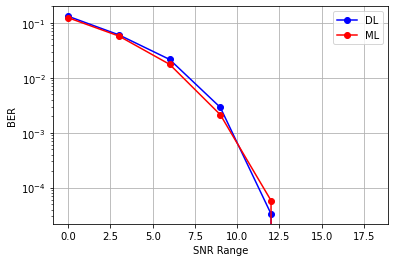

In [5]:
def frange(x,y,jump):
    while x < y:
        yield x
        x +=jump

EbNodB_range = list(frange(0,21,3))
BER1 = [None]*len(EbNodB_range)


with tf.Session() as sess:
  #Training
    sess.run(init)
    for epoch in range(traing_epochs):
        avg_cost = 0
        for index_m in range(total_batch):
            input_samples = []
            input_samples1 = []
            input_labels = []
            
            for index_k in range(0, batch_size):
                bits1 = np.random.binomial(n=1,p=0.5,size=(q,))
                bits2 = np.random.binomial(n=1,p=0.5,size=(q,))
                signaloutput = SC_IM_NO_train(bits1,bits2,12)
                input_labels.append(bits1)
                input_samples.append(signaloutput)
                
               

            batch_x = np.asarray(input_samples)
            batch_xx = np.asarray(input_samples1)
            batch_y = np.asarray(input_labels)
           
            
            

            _,cs = sess.run([optimizer,cost], feed_dict={X:batch_x,
                                                        Y:batch_y,
                                                        learning_rate:l_rate})
            avg_cost += cs / total_batch
        if epoch % display_step == 0:
            print("Epoch:",'%04d' % (epoch+1), "cost=", \
               "{:.9f}".format(avg_cost))
  #==========Testing=============
    for n in range(0,len(EbNodB_range)):
      input_samples_test = []
      input_samples1_test = []
      input_labels_test = []
      test_number = 10000
      if n>3:
        test_number = 10000
      for i in range(0, test_number):
        bits1 = np.random.binomial(n=1, p=0.5, size=(q, )) 
        bits2 = np.random.binomial(n=1, p=0.5, size=(q, ))
        signaloutput = SC_IM_NO_train(bits1,bits2,EbNodB_range[n])
        input_labels_test.append(bits1)
        input_samples_test.append(signaloutput)
        
               

      batch_x = np.asarray(input_samples_test)
      batch_y = np.asarray(input_labels_test)
      
      mean_error_rate = 1-tf.reduce_mean(tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y_pred-0.5), tf.cast(tf.sign(batch_y-0.5),tf.float32))),1))
      BER1[n]  = mean_error_rate.eval({X:batch_x})
      print("SNR=", EbNodB_range[n], "BER:", BER1[n])
    ML1=[0.124500000000000,	0.0577833333333333,	0.0176583333333333,	0.00213333333333333	,5.83333333333333e-05	,0,	0]
    import matplotlib.pyplot as plt
    plt.plot(EbNodB_range, BER1, 'bo-',label='DL')
    plt.plot(EbNodB_range, ML1, 'ro-',label='ML')
    #plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
    plt.yscale('log')
    plt.xlabel('SNR Range')
    plt.ylabel('BER')
    plt.grid()
    plt.legend(loc='upper right',ncol = 1)
    #plt.savefig('DL_Detection_IM_BER_matplotlib')
    plt.show()

In [18]:
X = tf.placeholder("float",[None, 8])
y_pred = encoder(X)
X1 = tf.concat((y_pred,X),axis=-1)
Y1 = tf.placeholder("float",[None, 3])
Y2 = tf.placeholder("float",[None, 3])
initializer = tf.contrib.layers.xavier_initializer()

def encoder1(a):
    weights = {
        'encoder_h1': tf.Variable(initializer([11, 112])),
        'encoder_h2': tf.Variable(initializer([112, 224])),
        'encoder_h3': tf.Variable(initializer([224, 3])),
        
    }
    
    biases = {
        'encoder_b1': tf.Variable(initializer([112])),
        'encoder_b2': tf.Variable(initializer([224])),
        'encoder_b3': tf.Variable(initializer([3])),
        
    }
    layer_1 = tf.nn.relu(tf.add(tf.matmul(a, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
   
    return layer_3


y2_pred = encoder1(X1)
y2_true = Y1
y_true = Y2

cost = tf.reduce_mean(tf.pow(y2_true - y2_pred,2)+tf.pow(y_true - y_pred,2))


learning_rate = tf.placeholder(tf.float32,shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
init = tf.global_variables_initializer()

Epoch: 0001 cost= 0.489961490
Epoch: 0006 cost= 0.348035839
Epoch: 0011 cost= 0.220252341
Epoch: 0016 cost= 0.145638222
Epoch: 0021 cost= 0.116423697
Epoch: 0026 cost= 0.093354939
Epoch: 0031 cost= 0.084804576
Epoch: 0036 cost= 0.078346589
Epoch: 0041 cost= 0.074630933
Epoch: 0046 cost= 0.068097559
Epoch: 0051 cost= 0.065536915
Epoch: 0056 cost= 0.060063728
Epoch: 0061 cost= 0.062097804
Epoch: 0066 cost= 0.056444184
Epoch: 0071 cost= 0.058560724
Epoch: 0076 cost= 0.051609767
Epoch: 0081 cost= 0.057937620
Epoch: 0086 cost= 0.057123976
Epoch: 0091 cost= 0.056323980
Epoch: 0096 cost= 0.050880779
Epoch: 0101 cost= 0.050307829
Epoch: 0106 cost= 0.050183613
Epoch: 0111 cost= 0.052611991
Epoch: 0116 cost= 0.053072440
Epoch: 0121 cost= 0.050406084
Epoch: 0126 cost= 0.052201755
Epoch: 0131 cost= 0.049869152
Epoch: 0136 cost= 0.051062396
Epoch: 0141 cost= 0.049850510
Epoch: 0146 cost= 0.054855818
Epoch: 0151 cost= 0.050896268
Epoch: 0156 cost= 0.055128120
Epoch: 0161 cost= 0.048094716
Epoch: 016

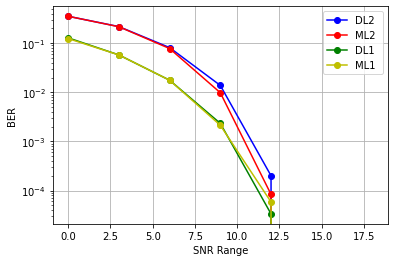

In [19]:
def frange(x,y,jump):
    while x < y:
        yield x
        x +=jump

EbNodB_range = list(frange(0,21,3))
BER1 = [None]*len(EbNodB_range)
BER2 = [None]*len(EbNodB_range)


with tf.Session() as sess:
  #Training
    sess.run(init)
    for epoch in range(traing_epochs):
        avg_cost = 0
        for index_m in range(total_batch):
            input_samples = []
            input_labels  = []
            input_labels1 = []
            

            
            for index_k in range(0, batch_size):
                bits1 = np.random.binomial(n=1,p=0.5,size=(q,))
                bits2 = np.random.binomial(n=1,p=0.5,size=(q,))
                signaloutput = SC_IM_NO_train(bits1,bits2,7)
                input_samples.append(signaloutput)
                input_labels.append(bits2)
                input_labels1.append(bits1)
                

            batch_1 = np.asarray(input_samples)
            batch_2 = np.asarray(input_labels)
            batch_3 = np.asarray(input_labels1)
            
           
            
            

            _,cs = sess.run([optimizer,cost], feed_dict={X:batch_1,
                                                        Y1:batch_2,Y2:batch_3,
                                                        learning_rate:l_rate})
            avg_cost += cs / total_batch
        if epoch % display_step == 0:
            print("Epoch:",'%04d' % (epoch+1), "cost=", \
               "{:.9f}".format(avg_cost))
  #==========Testing=============
    for n in range(0,len(EbNodB_range)):
      input_samples_test = []
      input_labels_test = []
      input_labels1_test = []
      
      test_number = 10000
      if n>10:
        test_number = 10000
      for i in range(0, test_number):
        bits1 = np.random.binomial(n=1, p=0.5, size=(q, )) 
        bits2 = np.random.binomial(n=1, p=0.5, size=(q, ))
        signaloutput = SC_IM_NO_train(bits1,bits2,EbNodB_range[n])
        input_samples_test.append(signaloutput)
        input_labels_test.append(bits2)
        input_labels1_test.append(bits1)
       
               

      batch_1 = np.asarray(input_samples_test)
      batch_2 = np.asarray(input_labels_test)
      batch_3 = np.asarray(input_labels1_test)
      
      mean_error_rate1 = 1-tf.reduce_mean(tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y_pred-0.5), tf.cast(tf.sign(batch_3-0.5),tf.float32))),1))
      BER1[n]  = mean_error_rate1.eval({X:batch_1,Y2:batch_3})
      print("SNR1=", EbNodB_range[n], "BER1:", BER1[n])
      
      mean_error_rate2 = 1-tf.reduce_mean(tf.reduce_mean(tf.to_float(tf.equal(tf.sign(y2_pred-0.5), tf.cast(tf.sign(batch_2-0.5),tf.float32))),1))
      BER2[n]  = mean_error_rate2.eval({X:batch_1,Y1:batch_2,Y2:batch_3})
      print("SNR2=", EbNodB_range[n], "BER2:", BER2[n])
    ML1=[0.124500000000000,	0.0577833333333333,	0.0176583333333333,	0.00213333333333333	,5.83333333333333e-05	,0,	0]
    ML2=[0.354208333333333,	0.217008333333333,	0.0779916666666667,	0.00982500000000000,	8.33333333333333e-05,	0	,0]
    import matplotlib.pyplot as plt
    plt.plot(EbNodB_range, BER2, 'bo-',label='DL2 ')
    plt.plot(EbNodB_range, ML2, 'ro-',label='ML2 ')
    plt.plot(EbNodB_range, BER1, 'go-',label='DL1 ')
    plt.plot(EbNodB_range, ML1, 'yo-',label='ML1 ')
    #plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
    plt.yscale('log')
    plt.xlabel('SNR Range')
    plt.ylabel('BER')
    plt.grid()
    plt.legend(loc='upper right',ncol = 1)
    #plt.savefig('DL_Detection_IM_BER_matplotlib')
    plt.show()